## OPeNDAP Access
### Notebook Objectives:
* Search the common metadata repository (CMR) for the MUR dataset
* Obtain OPeNDAP links from CMR search
* Download data from OPeNDAP links and open via xarray to visualize data

In [1]:
#https://ghrc.nsstc.nasa.gov/opendap/globalir/data/2020/0525/globir.20146.0000
from netCDF4 import Dataset
import xarray as xr
import dask
import os
import requests

#Allows us to visualize the dask progress for parallel operations
from dask.diagnostics import ProgressBar
ProgressBar().register()


/home/luisfigueiredo/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Before you start
Before you beginning this tutorial, make sure you have an account in the Earthdata Login, which is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register for an Earthdata Login account. It is free to create and only takes a moment to set up.

You will also need a netrc file containing your NASA Earthdata Login credentials in order to execute this notebook. A netrc file can be created manually within text editor and saved to your home directory. For additional information see: Authentication for NASA Earthdata

In this notebook, we will be calling the authentication in the below cell, a work around if you do not yet have a netrc file.

## Authentication for NASA Earthdata

This notebook creates a hidden .netrc file (_netrc for Window OS) with Earthdata login credentials in your home directory. This file is needed to access NASA Earthdata assets from a scripting environment like Python.


In [2]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os

In [3]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)

In [ ]:
#The .netrc file with my credentials was created in the home directory

In [4]:
import urllib
from urllib import request, parse
from http.cookiejar import CookieJar
import json
import getpass
import netrc

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file
    first and if no credentials are found, it prompts for them.
    Valid endpoints include:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

edl="urs.earthdata.nasa.gov"

setup_earthdata_login_auth(edl)

In [ ]:
# Please provide your Earthdata Login credentials to allow data access
# Your credentials will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter

In [5]:
#CMR Link to use
#https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1625128926-GHRC_CLOUD&temporal=2019-01-01T10:00:00Z,2019-12-31T23:59:59Z
r = requests.get('https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1996881146-POCLOUD&temporal=2023-05-05T10:00:00Z,2023-05-07T10:00:00Z&pageSize=365')
response_body = r.json()

In [6]:
od_files = []
for itm in response_body['items']:
    for urls in itm['umm']['RelatedUrls']:
        if 'OPeNDAP' in urls['Description']:
            od_files.append(urls['URL'])

od_files

['https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230505090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230506090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230507090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1']

In [7]:
len(od_files)

3

In [7]:
for f in od_files:
    print (" opening " + f)
    data_url = f'{f}.dap.nc4'
    
    
    # The notation below is [start index, step, end index]
    # lat[ /lat= 0..17998] start index. = -90
    # lon[ /lon= 0..35999] start index. = -180
    # time[ /time= 0..0] 
    #required_variables = {'analysed_sst[0:1:0][14498:1:15498][7100:1:8500]',
     #                     'lat[14498:1:15498]',
      #                    'lon[7100:1:8500]',
       #                   'time[0:1:0]'}
    
    #required_variables = {'analysed_sst[0:1:0][000:1:17997][000:1:35998]',
     #                     'lat[000:1:17997]',
      #                    'lon[000:1:35998]',
       #                   'time[0:1:0]'}
    
    required_variables = {'analysed_sst[0:1:0][12499:1:13499][16099:1:17499]',
                          'lat[12499:1:13499]',
                          'lon[16099:1:17499]',
                          'time[0:1:0]'}


    
    
    #upper latitude, left longitude, lower latitude, right longitude

    basename = os.path.basename(data_url)
    request_params = {'dap4.ce': ';'.join(required_variables)}
    #identity encoding to work around an issue with server side response compression (??)
    response = requests.get(data_url, params=request_params,  headers={'Accept-Encoding': 'identity'})

    basename = os.path.join('../data/MUR_daily_data', basename)
    
    print(basename)
    
    if response.ok:
        with open(basename, 'wb') as file_handler:
            file_handler.write(response.content)
    else:
        print(f'Request failed: {response.text}')

 opening https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230505090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
../data/MUR_daily_data/20230505090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.dap.nc4
 opening https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230506090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
../data/MUR_daily_data/20230506090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.dap.nc4
 opening https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230507090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
../data/MUR_daily_data/20230507090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.dap.nc4


In [8]:
#merge individual files by time and delete them afterwards


# Set the path to the directory containing the NetCDF files
data_dir = '../data/MUR_daily_data'

# Get a list of all NetCDF files in the directory
file_list = [file for file in os.listdir(data_dir) if file.endswith('.dap.nc4')]

# Load the NetCDF files into a list of xarray datasets
datasets = [xr.open_dataset(os.path.join(data_dir, file)) for file in file_list]

# Concatenate the datasets along the time dimension
merged_dataset = xr.concat(datasets, dim='time')

# Close the individual datasets
for ds in datasets:
    ds.close()

# Delete the individual NetCDF files
for file in file_list:
    os.remove(os.path.join(data_dir, file))

# Save the merged dataset to a new NetCDF file
merged_dataset.to_netcdf(os.path.join(data_dir, 'merged_data.nc'))

# Close the merged dataset
merged_dataset.close()

In [9]:
cloud_data = xr.open_mfdataset('../data/MUR_daily_data/merged_data.nc', engine='netcdf4')

In [10]:
cloud_data

<xarray.Dataset>
Dimensions:       (lat: 1001, lon: 1401, time: 3)
Coordinates:
  * lon           (lon) float32 -19.0 -18.99 -18.98 -18.97 ... -5.02 -5.01 -5.0
  * time          (time) datetime64[ns] 2023-05-05T09:00:00 ... 2023-05-07T09...
  * lat           (lat) float32 35.0 35.01 35.02 35.03 ... 44.98 44.99 45.0
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(3, 1001, 1401), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                         CF-1.7
    title:                               Daily MUR SST, Final product
    summary:                             A merged, multi-sensor L4 Foundation...
    references:                          http://podaac.jpl.nasa.gov/Multi-sca...
    institution:                         Jet Propulsion Laboratory
    history:                             created at nominal 4-day latency; re...
    ...                                  ...
    build_dmrpp_metadata.build_dmrpp:    3.20.13-184
    build_dmrpp_metadata.bes:            3.20.13-184
    build_dmrpp_metadata.libdap:         libdap-3.20.11-59
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_u9vw -f...
    history_json:                        [{"$schema":"https:\/\/harmony.earth...

In [9]:
import xarray as xr
cloud_data = xr.open_mfdataset(basename, engine='netcdf4')

In [10]:
cloud_data

<xarray.Dataset>
Dimensions:       (lat: 1001, lon: 1401, time: 1)
Coordinates:
  * lon           (lon) float32 -19.0 -18.99 -18.98 -18.97 ... -5.02 -5.01 -5.0
  * time          (time) datetime64[ns] 2023-05-07T09:00:00
  * lat           (lat) float32 35.0 35.01 35.02 35.03 ... 44.98 44.99 45.0
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 1001, 1401), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                         CF-1.7
    title:                               Daily MUR SST, Interim near-real-tim...
    summary:                             A merged, multi-sensor L4 Foundation...
    references:                          http://podaac.jpl.nasa.gov/Multi-sca...
    institution:                         Jet Propulsion Laboratory
    history:                             near real time (nrt) version created...
    ...                                  ...
    build_dmrpp_metadata.build_dmrpp:    3.20.13-184
    build_dmrpp_metadata.bes:            3.20.13-184
    build_dmrpp_metadata.libdap:         libdap-3.20.11-59
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_wDto -f...
    history_json:                        [{"$schema":"https:\/\/harmony.earth...

In [11]:
analysed_sst = cloud_data['analysed_sst'][0,:,:].values

[########################################] | 100% Completed |  0.1s


In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 12, 10
import numpy as np
import cv2

def sst_visualization(sst_array, data_xarray):
    
    """
    Function to visualize the map the SST data.
    We use the sst data "analysed_sst" to create a mask for the continental zone.
    """
    
    #first we apply the frontal_prob function to a certain period of data
    fp = sst_array.copy()
    fp = np.flip(fp, axis=0)  #flip along the horizontl axis
 
    sst = data_xarray['analysed_sst'].values[0]
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    #for the definition of the extent in the imshow() -> so we see the values of long and latitude in our plot
    lat = np.array(np.unique(data_xarray['lat'].values))
    lon = np.array(np.unique(data_xarray['lon'].values))

    plt.imshow(fp, cmap='viridis', extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.title("SST (MUR) ", fontsize=20)
    plt.show()

[########################################] | 100% Completed |  0.1s


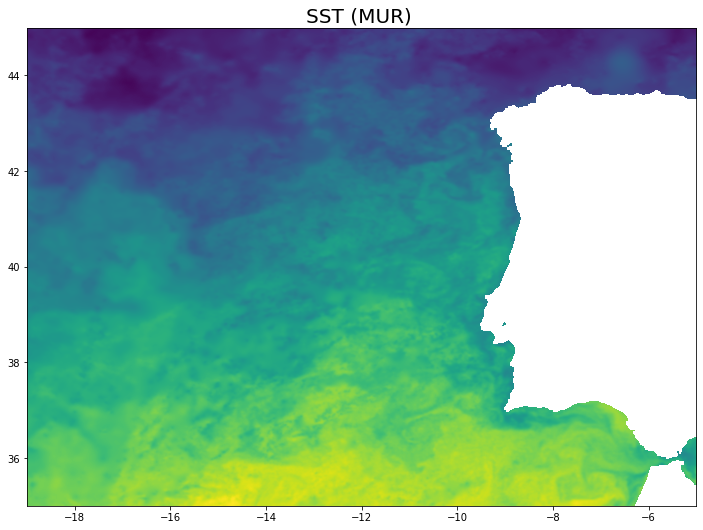

In [13]:
sst_visualization(analysed_sst, cloud_data)